# Gradient Boosting Models Exercise: Advanced Ensemble Methods

**ML2 Course - Extra Points Assignment (5 points)**

**Objective:**
The goal of this exercise is to explore and master various gradient boosting algorithms for panel data modeling. You will implement and compare seven state-of-the-art boosting models that represent the cutting edge of machine learning regression techniques.

**Models to Implement:**

1. **AdaBoost** ([AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)) - Adaptive Boosting, the pioneering boosting algorithm
2. **GBM** ([GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)) - Classic Gradient Boosting Machine from scikit-learn
3. **GBM Histogram** ([HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)) - Histogram-based Gradient Boosting (faster, inspired by LightGBM)
4. **XGBoost** ([XGBRegressor](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor)) - Extreme Gradient Boosting, industry standard
5. **LightGBM** ([LGBMRegressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)) - Light Gradient Boosting Machine, optimized for speed and memory
6. **CatBoost** ([CatBoostRegressor](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor)) - Categorical Boosting, handles categorical features natively
7. **XGBoostLSS** ([XGBoostLSS](https://github.com/StatMixedML/XGBoostLSS)) - XGBoost for Location, Scale and Shape, probabilistic predictions

**Tasks Workflow:**

Following a similar process to the SVM / KNN model (`notebooks/07.knn-model.ipynb`):

1. **Load the prepared training data** from the preprocessing step
2. **Feature Engineering** (if necessary):
   - Note: Tree-based models do NOT require standardization/normalization
   - They are invariant to monotonic transformations of features
3. **Feature Selection**:
   - Use existing feature rankings from `feature_ranking.xlsx` for initial feature selection
   - Consider feature importance from tree-based models
   - Test multiple feature sets (top 20, 30, 50 features, etc.) - please utilize Feature Importance directly from models
4. **Hyperparameter Tuning**: (2 points)
   - Use GridSearchCV or RandomizedSearchCV, or Optuna
   - Focus on key parameters: learning rate, boosting iterations, tree max depth, regularization (if applicable) etc. 
   - Use rolling window cross-validation to avoid data leakage
5. **Identify Local Champions**: (1 point)
   - Select the best model for each algorithm class
   - Compare based on RMSE on validation sets
6. **Save Models**:
   - Pickle the best models for each algorithm
   - Save to `../models/` directory

**Important Notes:**

- Gradient boosting models are powerful but prone to overfitting - pay attention to regularization
- Learning rate and number of estimators have an inverse relationship
- Early stopping can be used to prevent overfitting
- XGBoostLSS provides distributional forecasts (not just point estimates)
- Use time-series aware cross-validation (rolling window) for final model selection

**Model Evaluation:** (2 points)

After completing this notebook:
- Load your models in `notebooks/09.final-comparison-and-summary.ipynb`
- Compare them against existing models (OLS, ARMA, ARDL, KNN, SVR)
- Check if any gradient boosting model becomes the new champion!

---

## Submission Requirements

- Complete this notebook with code and outputs
- Save best model(s) as pickle files in `models/` directory
- Commit and push to your GitHub repository
- Send repository link to: **mj.wozniak9@uw.edu.pl**

**Deadline:** [To be announced by instructor]

In [33]:
from pathlib import Path
import json
import warnings
import pickle
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, ParameterGrid
from xgboost import XGBRegressor, DMatrix
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboostlss.model import XGBoostLSS
from xgboostlss.distributions.Gaussian import Gaussian
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)
SEED = 2000

In [34]:
DATA_DIR = Path("../data/output")
MODEL_DIR = Path("../models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# I had to remove certain characters from feature names to make them fully compatible with all models
def clean_feature_name(name: str) -> str:
    if not isinstance(name, str):
        return name
    translation_table = str.maketrans({"[":"", "]":"", "(":"", ")":"", " ":"", ",":""})
    return name.translate(translation_table)

train_raw = pd.read_csv(DATA_DIR / "train_fe.csv", index_col=0)
test_raw = pd.read_csv(DATA_DIR / "test_fe.csv", index_col=0)
ranking_raw = pd.read_excel(DATA_DIR / "feature_ranking.xlsx").rename(columns={"Unnamed: 0": "feature"})

train = train_raw.rename(columns=clean_feature_name).copy()
test = test_raw.rename(columns=clean_feature_name).copy()
ranking = ranking_raw.assign(feature=ranking_raw["feature"].map(clean_feature_name))

sort_cols = [col for col in ["rok", "Ticker"] if col in train.columns]
if sort_cols:
    train = train.sort_values(sort_cols).reset_index(drop=True)
    test = test.sort_values(sort_cols).reset_index(drop=True)

train.shape, test.shape

((3993, 115), (363, 115))

In [35]:
ranking['corr_abs'] = ranking['corr'].abs()

metric_tops = {
    'mi_score': ranking.nlargest(20, 'mi_score')['feature'].tolist(),
    'sign_fscore': ranking.nlargest(20, 'sign_fscore')['feature'].tolist(),
    'corr_abs': ranking.nlargest(20, 'corr_abs')['feature'].tolist(),
    'boruta_rank': ranking.loc[ranking['boruta_rank'].notna()].nsmallest(20, 'boruta_rank')['feature'].tolist(),
}

combined_features = sorted({feat for feats in metric_tops.values() for feat in feats})

selected_features = [feat for feat in combined_features if feat in train.columns]

summary_rows = []
for metric, feats in metric_tops.items():
    for feat in feats:
        summary_rows.append({'metric': metric, 'feature': feat})
feature_summary = pd.DataFrame(summary_rows)

print(f"Unique features selected: {len(selected_features)}")
feature_summary.head(12)

Unique features selected: 56


,metric,feature
0,mi_score,etr_y_past
1,mi_score,etr_y_ma
2,mi_score,txt
3,mi_score,diff
4,mi_score,ni
5,mi_score,pi
6,mi_score,intant
7,mi_score,intant_sqrt
8,mi_score,ta
9,mi_score,revenue


In [36]:
TARGET = 'etr'

base_features = selected_features.copy()
X_train_full = train[base_features].copy()
X_test_full = test[base_features].copy()

y_train = train[TARGET].copy()
y_test = test[TARGET].copy()

tscv = TimeSeriesSplit(n_splits=5)

X_train_full.shape, X_test_full.shape

((3993, 56), (363, 56))

In [37]:
RMSE_SCORER = 'neg_root_mean_squared_error'
cv_leaderboard = []
test_performance = []

def run_grid_search(name, estimator, param_grid, X, y, n_jobs=-1):
    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=RMSE_SCORER,
        cv=tscv,
        n_jobs=n_jobs,
        verbose=0,
        error_score='raise',
        return_train_score=False,
    )
    grid.fit(X, y)
    print(f"{name}: best CV RMSE = {-grid.best_score_:.4f}")
    return grid

def evaluate_on_test(name, model, X, y):
    preds = model.predict(X)
    rmse = float(np.sqrt(mean_squared_error(y, preds)))
    mae = float(mean_absolute_error(y, preds))
    print(f"{name}: TEST RMSE={rmse:.4f} | MAE={mae:.4f}")
    return {'model': name, 'rmse': rmse, 'mae': mae}

In [38]:
importance_model = GradientBoostingRegressor(random_state=SEED)
importance_model.fit(X_train_full, y_train)
importances = pd.Series(importance_model.feature_importances_, index=base_features)
feature_importances = importances.sort_values(ascending=False)
feature_importances.head(10)

etr_y_ma      0.288166
etr_y_past    0.132263
diff          0.072477
diff_ma       0.065042
WB_GDPpc      0.039396
txt           0.033265
capex         0.025298
rok           0.018998
sale          0.018476
diff_dta      0.017445
dtype: float64

In [39]:
feature_sets = {}
for k in [20, 30, 50]:
    k = min(k, len(feature_importances))
    feature_sets[f'top_{k}'] = feature_importances.head(k).index.tolist()
feature_sets['top_all'] = feature_importances.index.tolist()

feature_set_summary = pd.DataFrame(
    [(name, len(cols)) for name, cols in feature_sets.items()],
    columns=['feature_set', 'num_features']
).sort_values('num_features')
feature_set_summary

,feature_set,num_features
0,top_20,20
1,top_30,30
2,top_50,50
3,top_all,56


In [41]:
model_space = [
    {
        'name': 'AdaBoost',
        'estimator': AdaBoostRegressor(
            estimator=DecisionTreeRegressor(max_depth=3, random_state=SEED),
            random_state=SEED,
        ),
        'grid': {
            'n_estimators': [200, 400],
            'learning_rate': [0.05, 0.1],
            'loss': ['linear', 'square'],
        },
        'n_jobs': -1,
    },
    {
        'name': 'GBM',
        'estimator': GradientBoostingRegressor(random_state=SEED),
        'grid': {
            'n_estimators': [200, 500],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 6],
            'subsample': [0.6, 1.0],
            'max_features': [None, 'sqrt'],
        },
        'n_jobs': -1,
    },
    {
        'name': 'HistGBM',
        'estimator': HistGradientBoostingRegressor(random_state=SEED),
        'grid': {
            'learning_rate': [0.05, 0.1],
            'max_depth': [None, 4],
            'l2_regularization': [0.0, 0.5],
            'min_samples_leaf': [10, 30],
        },
        'n_jobs': -1,
    },
    {
        'name': 'XGBoost',
        'estimator': XGBRegressor(
            objective='reg:squarederror',
            tree_method='hist',
            random_state=SEED,
            n_jobs=-1,
            eval_metric='rmse',
        ),
        'grid': {
            'n_estimators': [250, 500],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5],
            'subsample': [0.7, 0.9],
            'reg_lambda': [1.0, 5.0],
        },
        'n_jobs': 1,
    },
    {
        'name': 'LightGBM',
        'estimator': LGBMRegressor(
            objective='regression',
            random_state=SEED,
            verbose=-1,
            n_jobs=-1,
            force_row_wise=True,
        ),
        'grid': {
            'n_estimators': [200, 600],
            'learning_rate': [0.05, 0.1],
            'max_depth': [-1, 3],
            'reg_lambda': [0.0, 1.0],
        },
        'n_jobs': -1,
    },
    {
        'name': 'CatBoost',
        'estimator': CatBoostRegressor(
            loss_function='RMSE',
            random_state=SEED,
            allow_writing_files=False,
            verbose=0,
        ),
        'grid': {
            'depth': [3, 6],
            'learning_rate': [0.05, 0.1],
            'iterations': [300, 500],
            'l2_leaf_reg': [3],
        },
        'n_jobs': 1,
    },
 ]

feature_set_estimators = {fs: {} for fs in feature_sets}
best_models_map = {}
best_estimators = {}

for fs_name, fs_cols in feature_sets.items():
    print(f"\n=== Feature set: {fs_name} ({len(fs_cols)} features) ===")
    X_tr = X_train_full[fs_cols]
    X_te = X_test_full[fs_cols]
    for spec in model_space:
        grid = run_grid_search(spec['name'], spec['estimator'], spec['grid'], X_tr, y_train, n_jobs=spec['n_jobs'])
        best_estimator = grid.best_estimator_
        feature_set_estimators[fs_name][spec['name']] = best_estimator
        cv_leaderboard.append({
            'feature_set': fs_name,
            'model': spec['name'],
            'best_params': grid.best_params_,
            'cv_rmse': -grid.best_score_,
        })
        eval_record = evaluate_on_test(spec['name'], best_estimator, X_te, y_test)
        eval_record['feature_set'] = fs_name
        test_performance.append(eval_record)
        if (spec['name'] not in best_models_map) or (eval_record['rmse'] < best_models_map[spec['name']]['rmse']):
            best_models_map[spec['name']] = {
                'feature_set': fs_name,
                'rmse': eval_record['rmse'],
                'mae': eval_record['mae'],
                'best_params': grid.best_params_,
                'estimator': best_estimator,
                'features': list(fs_cols),
            }
            best_estimators[spec['name']] = best_estimator


=== Feature set: top_20 (20 features) ===
AdaBoost: best CV RMSE = 0.1558
AdaBoost: TEST RMSE=0.0925 | MAE=0.0678
AdaBoost: best CV RMSE = 0.1558
AdaBoost: TEST RMSE=0.0925 | MAE=0.0678
GBM: best CV RMSE = 0.1491
GBM: TEST RMSE=0.0800 | MAE=0.0542
GBM: best CV RMSE = 0.1491
GBM: TEST RMSE=0.0800 | MAE=0.0542
HistGBM: best CV RMSE = 0.1488
HistGBM: TEST RMSE=0.0803 | MAE=0.0546
HistGBM: best CV RMSE = 0.1488
HistGBM: TEST RMSE=0.0803 | MAE=0.0546
XGBoost: best CV RMSE = 0.1509
XGBoost: TEST RMSE=0.0795 | MAE=0.0540
XGBoost: best CV RMSE = 0.1509
XGBoost: TEST RMSE=0.0795 | MAE=0.0540
LightGBM: best CV RMSE = 0.1488
LightGBM: TEST RMSE=0.0807 | MAE=0.0553
LightGBM: best CV RMSE = 0.1488
LightGBM: TEST RMSE=0.0807 | MAE=0.0553
CatBoost: best CV RMSE = 0.1501
CatBoost: TEST RMSE=0.0786 | MAE=0.0536

=== Feature set: top_30 (30 features) ===
CatBoost: best CV RMSE = 0.1501
CatBoost: TEST RMSE=0.0786 | MAE=0.0536

=== Feature set: top_30 (30 features) ===
AdaBoost: best CV RMSE = 0.1554
Ada

In [42]:
xgblss_param_grid = ParameterGrid({
    'eta': [0.05, 0.1],
    'max_depth': [3, 5],
    'lambda': [1.0, 3.0],
})

for fs_name, fs_cols in feature_sets.items():
    print(f"\n[XGBoostLSS] Feature set: {fs_name} ({len(fs_cols)} features)")
    X_tr = X_train_full[fs_cols]
    X_te = X_test_full[fs_cols]
    xgblss_trials = []
    for params in xgblss_param_grid:
        fold_scores = []
        for fold_id, (train_idx, val_idx) in enumerate(tscv.split(X_tr), start=1):
            dist = Gaussian()
            model = XGBoostLSS(dist)
            dtrain = DMatrix(X_tr.iloc[train_idx], label=y_train.iloc[train_idx])
            dval = DMatrix(X_tr.iloc[val_idx], label=y_train.iloc[val_idx])
            evals = [(dtrain, 'train'), (dval, 'validation')]
            model.train(
                params={**params, 'booster': 'gbtree', 'tree_method': 'hist', 'seed': SEED},
                dtrain=dtrain,
                num_boost_round=600,
                evals=evals,
                early_stopping_rounds=50,
                verbose_eval=False,
            )
            pred_df = model.predict(dval, pred_type='parameters')
            rmse = float(np.sqrt(mean_squared_error(y_train.iloc[val_idx], pred_df['loc'].values)))
            fold_scores.append(rmse)
        mean_rmse = float(np.mean(fold_scores))
        xgblss_trials.append({'params': params, 'cv_rmse': mean_rmse})
        print(f"Params {params} -> CV RMSE {mean_rmse:.4f}")
    best_xgblss = min(xgblss_trials, key=lambda row: row['cv_rmse'])
    best_params = {**best_xgblss['params'], 'booster': 'gbtree', 'tree_method': 'hist', 'seed': SEED}
    print(
        f"Best XGBoostLSS params ({fs_name}): {best_params} | CV RMSE {best_xgblss['cv_rmse']:.4f}")
    dist = Gaussian()
    xgblss_model = XGBoostLSS(dist)
    dtrain_full = DMatrix(X_tr, label=y_train)
    xgblss_model.train(
        params=best_params,
        dtrain=dtrain_full,
        num_boost_round=600,
        evals=None,
        verbose_eval=False,
        early_stopping_rounds=None,
    )
    feature_set_estimators[fs_name]['XGBoostLSS'] = xgblss_model
    cv_leaderboard.append({
        'feature_set': fs_name,
        'model': 'XGBoostLSS',
        'best_params': best_params,
        'cv_rmse': best_xgblss['cv_rmse'],
    })
    dtest = DMatrix(X_te, label=y_test)
    preds = xgblss_model.predict(dtest, pred_type='parameters')['loc'].values
    rmse = float(np.sqrt(mean_squared_error(y_test, preds)))
    mae = float(mean_absolute_error(y_test, preds))
    eval_record = {'model': 'XGBoostLSS', 'rmse': rmse, 'mae': mae, 'feature_set': fs_name}
    test_performance.append(eval_record)
    if ('XGBoostLSS' not in best_models_map) or (rmse < best_models_map['XGBoostLSS']['rmse']):
        best_models_map['XGBoostLSS'] = {
            'feature_set': fs_name,
            'rmse': rmse,
            'mae': mae,
            'best_params': best_params,
            'estimator': xgblss_model,
            'features': list(fs_cols),
        }
        best_estimators['XGBoostLSS'] = xgblss_model
    print(f"XGBoostLSS ({fs_name}): TEST RMSE={rmse:.4f} | MAE={mae:.4f}")


[XGBoostLSS] Feature set: top_20 (20 features)
Params {'eta': 0.05, 'lambda': 1.0, 'max_depth': 3} -> CV RMSE 0.1489
Params {'eta': 0.05, 'lambda': 1.0, 'max_depth': 3} -> CV RMSE 0.1489
Params {'eta': 0.05, 'lambda': 1.0, 'max_depth': 5} -> CV RMSE 0.1490
Params {'eta': 0.05, 'lambda': 1.0, 'max_depth': 5} -> CV RMSE 0.1490
Params {'eta': 0.05, 'lambda': 3.0, 'max_depth': 3} -> CV RMSE 0.1485
Params {'eta': 0.05, 'lambda': 3.0, 'max_depth': 3} -> CV RMSE 0.1485
Params {'eta': 0.05, 'lambda': 3.0, 'max_depth': 5} -> CV RMSE 0.1499
Params {'eta': 0.05, 'lambda': 3.0, 'max_depth': 5} -> CV RMSE 0.1499
Params {'eta': 0.1, 'lambda': 1.0, 'max_depth': 3} -> CV RMSE 0.1494
Params {'eta': 0.1, 'lambda': 1.0, 'max_depth': 3} -> CV RMSE 0.1494
Params {'eta': 0.1, 'lambda': 1.0, 'max_depth': 5} -> CV RMSE 0.1514
Params {'eta': 0.1, 'lambda': 1.0, 'max_depth': 5} -> CV RMSE 0.1514
Params {'eta': 0.1, 'lambda': 3.0, 'max_depth': 3} -> CV RMSE 0.1502
Params {'eta': 0.1, 'lambda': 3.0, 'max_depth':

In [43]:
best_feature_set_summary = (
    pd.DataFrame([
        {
            'model': model,
            'feature_set': payload['feature_set'],
            'rmse': payload['rmse'],
            'mae': payload['mae'],
            'best_params': payload['best_params'],
        }
        for model, payload in best_models_map.items()
    ])
    .sort_values('rmse')
    .reset_index(drop=True)
)
best_feature_set_summary

,model,feature_set,rmse,mae,best_params
0,CatBoost,top_50,0.077766,0.052639,"{'depth': 6, 'iterations': 300, 'l2_leaf_reg':..."
1,HistGBM,top_50,0.079462,0.054048,"{'l2_regularization': 0.0, 'learning_rate': 0...."
2,XGBoost,top_20,0.079501,0.053989,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est..."
3,GBM,top_20,0.079961,0.054205,"{'learning_rate': 0.05, 'max_depth': 3, 'max_f..."
4,LightGBM,top_20,0.080704,0.055303,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est..."
5,XGBoostLSS,top_20,0.082065,0.056052,"{'eta': 0.05, 'lambda': 3.0, 'max_depth': 3, '..."
6,AdaBoost,top_30,0.091576,0.066001,"{'learning_rate': 0.05, 'loss': 'linear', 'n_e..."


In [44]:
cv_df = (
    pd.DataFrame(cv_leaderboard)
    .sort_values('cv_rmse')
    .reset_index(drop=True)
    .assign(rank=lambda df: df.index + 1)
    [['rank', 'feature_set', 'model', 'cv_rmse', 'best_params']]
 )
cv_df

,rank,feature_set,model,cv_rmse,best_params
0,1,top_20,XGBoostLSS,0.148454,"{'eta': 0.05, 'lambda': 3.0, 'max_depth': 3, '..."
1,2,top_30,GBM,0.148601,"{'learning_rate': 0.05, 'max_depth': 3, 'max_f..."
2,3,top_50,XGBoostLSS,0.148637,"{'eta': 0.05, 'lambda': 1.0, 'max_depth': 5, '..."
3,4,top_30,XGBoostLSS,0.148658,"{'eta': 0.05, 'lambda': 3.0, 'max_depth': 5, '..."
4,5,top_all,HistGBM,0.148676,"{'l2_regularization': 0.0, 'learning_rate': 0...."
5,6,top_50,HistGBM,0.148677,"{'l2_regularization': 0.0, 'learning_rate': 0...."
6,7,top_all,XGBoostLSS,0.148762,"{'eta': 0.05, 'lambda': 1.0, 'max_depth': 3, '..."
7,8,top_20,LightGBM,0.148823,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est..."
8,9,top_20,HistGBM,0.148824,"{'l2_regularization': 0.0, 'learning_rate': 0...."
9,10,top_20,HistGBM,0.148824,"{'l2_regularization': 0.0, 'learning_rate': 0...."


In [45]:
test_df = (
    pd.DataFrame(test_performance)
    .sort_values('rmse')
    .reset_index(drop=True)
    .assign(rank=lambda df: df.index + 1)
    [['rank', 'feature_set', 'model', 'rmse', 'mae']]
 )
test_df

,rank,feature_set,model,rmse,mae
0,1,top_50,CatBoost,0.077766,0.052639
1,2,top_20,CatBoost,0.078598,0.053631
2,3,top_50,HistGBM,0.079462,0.054048
3,4,top_all,HistGBM,0.079462,0.054048
4,5,top_20,XGBoost,0.079501,0.053989
5,6,top_20,XGBoost,0.079501,0.053989
6,7,top_30,HistGBM,0.079770,0.054459
7,8,top_20,GBM,0.079961,0.054205
8,9,top_20,GBM,0.079961,0.054205
9,10,top_50,GBM,0.080262,0.053862


#### Feature-set level performance
Averaging RMSE/MAE across models makes it easier to see whether deeper feature pools are consistently helpful.

In [46]:
feature_set_performance = (
    test_df.groupby('feature_set')[['rmse', 'mae']]
    .agg(['mean', 'std'])
    .sort_values(('rmse', 'mean'))
)
feature_set_performance

rmse                 mae          
                 mean       std      mean       std
feature_set                                        
top_20       0.082733  0.005044  0.057220  0.005269
top_all      0.082911  0.005294  0.056770  0.005387
top_50       0.083117  0.006057  0.056914  0.005970
top_30       0.083234  0.004835  0.056821  0.004383

In [47]:
model_paths = {}
for name, estimator in best_estimators.items():
    filename = f"{name.lower().replace(' ', '_')}_gradient_model.sav"
    path = MODEL_DIR / filename
    if name == 'XGBoostLSS':
        estimator.save_model(path)
    else:
        with open(path, 'wb') as f:
            pickle.dump(estimator, f)
    model_paths[name] = path.as_posix()
model_paths

{'AdaBoost': '../models/adaboost_gradient_model.sav',
 'GBM': '../models/gbm_gradient_model.sav',
 'HistGBM': '../models/histgbm_gradient_model.sav',
 'XGBoost': '../models/xgboost_gradient_model.sav',
 'LightGBM': '../models/lightgbm_gradient_model.sav',
 'CatBoost': '../models/catboost_gradient_model.sav',
 'XGBoostLSS': '../models/xgboostlss_gradient_model.sav'}

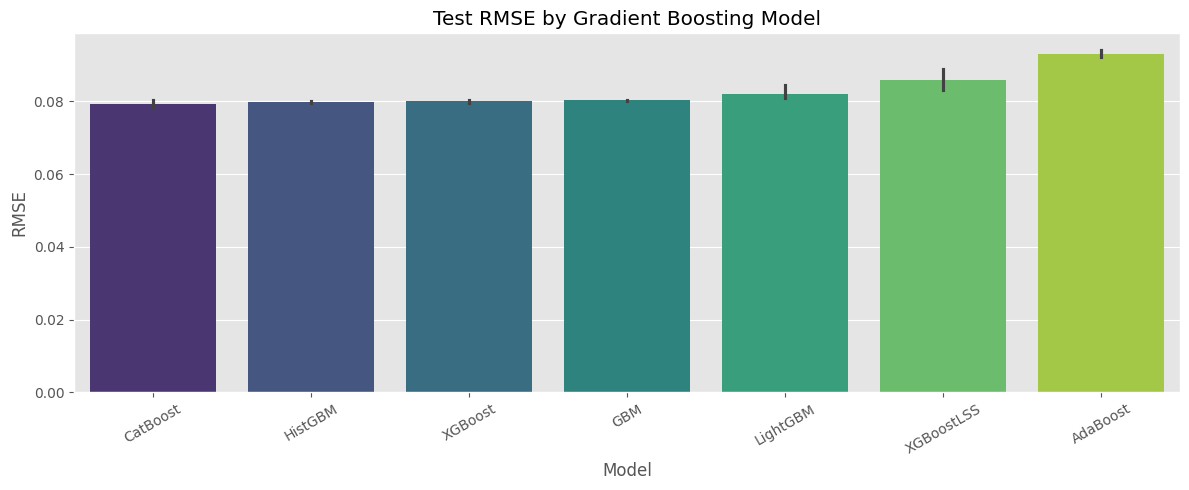

In [48]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 5))
sns.barplot(data=test_df, x='model', y='rmse', palette='viridis')
plt.title('Test RMSE by Gradient Boosting Model')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.xticks(rotation=30)
plt.tight_layout()